# Assigment - Weakly interacting and confined bosons at low density

### _Authors:_ Clàudia Garcia and Adrià Rojo

L'equació de Gross-Pitaevskii (GP) ens permet descriure els experiments de condensats de Bose-Einstein dins del marc tèoric. 

En aquest exemple, considerem N àtoms de $^{87}\text{Rb}$, on tots els àtoms estàn confinats per un camp magnètic, i tots els efectes d'aquest es descriuen bé per un potencial harmònic. També considerem que $\Psi(\vec{r})$ està normalitzat a la unitat. L'equació GP és la següent:

$$
\left[-\frac{1}{2} \nabla^2+\frac{1}{2} r_1^2+4 \pi \bar{a}_s N\left|\bar{\Psi}\left(\vec{r}_1\right)\right|^2\right] \bar{\Psi}\left(\vec{r}_1\right)=\bar{\mu} \bar{\Psi}\left(\vec{r}_1\right),
$$

on $\mu$ és el potencial químic, $N$ el nombre de partícules i $\bar{a}_s$ és la longitud de $s$-wave scattering. L'equació està escrita en unitats de oscil·lador harmònic.

Començarem per precomputar valors de distància i variables de la simulació i la funció d'ona inicial i fer tots els `imports`. Per la segona derivada utilitzarem la funció `gradient` de `numpy`. Utilitzarem `tqdm` per iterar el bucle i tenir una estimació del temps d'execució. El codi utilitza de forma extensiva generadors, per evitar l'anidament en un segon bucle `for`. 

In [15]:
import numpy as np
import numpy.typing as npt
from tqdm import tqdm
from IPython.display import display, Math, Markdown, clear_output
import typing as t

def second_derivative(fun: npt.ArrayLike, h: float) -> npt.ArrayLike:
    first = np.gradient(fun, h)
    return np.gradient(first, h)

def initial_values(scattering_length: float, width:float, step:float, atom_numbers:int, alpha:float) -> \
    t.Tuple[float, float, float, float, npt.ArrayLike, npt.ArrayLike, npt.ArrayLike]:
    alpha2 = alpha*alpha
    cvar = 2 * np.power(alpha, 3/2)/ np.power(np.pi, 1/4)
    rs = np.array([i * step for i in range(width)])
    r2s = rs**2
    psi = np.array([cvar*r*np.exp(-0.5*alpha2*r2) for (r, r2) in zip(rs, r2s)])
    interaction = scattering_length*atom_numbers #4*pi*a_s*N 
    density_param = atom_numbers*scattering_length**3
    return alpha2, cvar, interaction, density_param, rs, r2s, psi


La funció `compute_wavelength` farà l'evolució de la funció d'ona utilitzant l'equació de Gross-Pitaevskii depenent del temps i utilitzant l'aproximació de Bogoliuvob. També calcularà el potencial químic local, ja que ens servirà per fer la normalització a cada pas.

$$i\hbar\frac{\partial{\psi(\vec r, t)}}{\partial{t}} = \frac{\hbar^2}{2m}\nabla^2\psi(\vec r, t)+V_\text{ext}\psi(\vec r, t) + g\left|\psi(\vec r, t)\right|^2\psi(\vec r, t) \qquad
\mu(r) = \frac{-\frac{1}{2}\frac{d^2\psi}{dr^2} + \frac{1}{2}r^2\psi(r) + g\frac{|\psi(r)|^2}{r^2}\psi(r)}{\psi(r)} $$

La funció `final_properties` calcularà propietats finals de la simulació (no se podia saber), calculant els seguents valors:

$$ \langle r^2 \rangle = \int^\infty_0{r^2\left| \psi(r_1)\right|^2 dr_1} \approx \sum^\infty_{r_i = 0}{r_i^2\left| \psi(r_i)\right|^2}\Delta r \qquad
\langle T \rangle = -\frac{1}{2}\int_0^\infty \psi(r) \frac{d^2\psi}{dr^2} \, dr \approx -\frac{1}{2}\sum_i \psi(r_i) \left(\frac{d^2\psi}{dr^2}\right)_i \Delta r\\
\langle V_{\text{harm}} \rangle = \frac{1}{2}\int_0^\infty r^2 |\psi(r)|^2 \, dr \approx \frac{1}{2}\sum_i r_i^2 |\psi(r_i)|^2 \Delta r \qquad
\langle V_{\text{int}} \rangle = \frac{g}{2}\int_0^\infty \frac{|\psi(r)|^4}{r^2} r^2 \, dr \approx \frac{g}{2}\sum_i r_i^2 \left(\frac{|\psi(r_i)|}{r_i}\right)^4 \Delta r \\
\langle \mu \rangle = \int_0^\infty \mu(r) |\psi(r)|^2 \, dr \approx \sum_i \mu(r_i) |\psi(r_i)|^2 \Delta r \\
E_{\text{total}} = \langle T \rangle + \langle V_{\text{harm}} \rangle + \langle V_{\text{int}} \rangle \qquad
n(r) = \begin{cases} 
\left(\frac{\psi(r)}{r}\right)^2 & \text{si } r \neq 0 \\
0 & \text{si } r = 0
\end{cases}$$

In [16]:
def calc_local_mu(r: float, r2: float, curr: float, dx2: float, interaction: float) -> float:
    return (-(dx2/curr if curr != 0 else 1)/2 + r2/2 + interaction*(curr/r if r != 0 else 1)**2) 
def calc_interaction_potential(r:float, r2: float, final: float, interaction: float) -> float:
    return r2*(final/r if r != 0 else 1)**4*interaction/2

calc_local_mu, calc_interaction_potential = (np.vectorize(calc_local_mu), np.vectorize(calc_interaction_potential))

def final_properties(psi: npt.ArrayLike, local_mu: npt.ArrayLike, step: float, rs: npt.ArrayLike, r2s:npt.ArrayLike, interaction: float) -> \
    t.Dict[str, float]:
    psi_dx2 = second_derivative(psi, step)

    squared_radius = np.sum(r2s*psi*psi)*step
    avg_mu = np.sum(local_mu*psi*psi)*step
    kinetic_energy = -np.sum(psi*psi_dx2/2)*step
    harmonic_potential = np.sum(r2s*psi*psi/2)*step
    g_energy = np.sum(calc_interaction_potential(rs, r2s, psi, interaction))*step
    total_energy = kinetic_energy + harmonic_potential + g_energy
    return {
        "r^2": squared_radius,
        "avg mu": avg_mu,
        "kin energy": kinetic_energy,
        "armonic pot" : harmonic_potential,
        "interac energy": g_energy,
        "total energy": total_energy,
    }

def compute_wavelength(rs: npt.ArrayLike, r2s: npt.ArrayLike, psi: npt.ArrayLike, iterations: int, step: float, interaction: float, time_step: float, label: str=None) -> \
        t.Tuple[npt.ArrayLike, npt.ArrayLike]:
    psi_curr = psi
    for i in tqdm(range(iterations), desc=label):
        psi_dx2 = second_derivative(psi_curr, step)
        # calculo de energia y mu local
        local_mu = calc_local_mu(rs, r2s, psi_curr, psi_dx2, interaction)
        psi_next = psi_curr*(1 - time_step*local_mu)
        normalization_const = np.sqrt(np.sum(psi_next*psi_next)*step)
        psi_curr = psi_next/normalization_const

    local_mu = calc_local_mu(rs, r2s, psi_curr, psi_dx2, interaction)

    return (psi_curr, local_mu)

### a0) Terme d'interacció nul.

Si considerem el terme d'interacció nul (en el nostre programa la variable `interaction`), l'equació GP queda com: 

$$
\left[-\frac{1}{2} \nabla^2+\frac{1}{2} r_1^2\right] \bar{\Psi}\left(\vec{r}_1\right)=\bar{\mu} \bar{\Psi}\left(\vec{r}_1\right),
$$

Que com veiem
$
H_{o.h} = -\frac{1}{2} \nabla^2+\frac{1}{2} r_1^2,
$
 coincideix amb l'expressió de l'hamiltonià de l'oscil·lador harmònic en tres dimensions, per tant, tenim que: 
$H_{o.h} \bar{\Psi}\left(\vec{r}_1\right) = \varepsilon \bar{\Psi}\left(\vec{r}_1\right)$ i comparant ambdós equacions obtenim que $\bar{\mu} = \varepsilon$, és a dir, el potencial químic coincideix amb l'energia per partícula ($ \varepsilon = E/N$).

In [4]:
scattering_length, width,  step, atom_numbers, time_step, alpha, iterations = \
          0.00433,  400,  0.015,        10000,    0.0001,   0.8,      70000

alpha2, cvar, interaction, density_param, rs, r2s, psi = \
    initial_values(scattering_length, width, step, atom_numbers, alpha)
interaction = 0 # sobreescribimos el valor

final, local_mu = compute_wavelength(rs, r2s, psi, iterations,step, interaction,time_step)

properties = final_properties(final, local_mu, step, rs, r2s, interaction)

display(Math("\\varepsilon = {total energy:.5f}, \\mu = {avg mu:.5f}".format(**properties)))
display(Math("\\varepsilon_{{kin}} = {kin energy:.5f}, \\varepsilon_{{o.h}} = {armonic pot:.5f}, \\varepsilon_{{int}} = {interac energy:.5f}".format(**properties)))

100%|██████████| 70000/70000 [00:09<00:00, 7535.30it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Podem observar que tant l'energia cinética com la de l'oscil·lador harmònic es reparteixen de forma igual l'energia, complint d'aquesta forma el teorema del virial per aquests casos. Evidentment, el terme d'energia d'interacció és igual a zero.

### a) Resolució de l'equació GP per a diferents $N$

Utilizant $\bar{a}_s = 0.00433$ resolem l'equació GP per diferents nombres de partícules ($N$) i obtenim els següents resultats per $\mu$ i les següents energies per partícules: total, cinètica, de l'oscil·lador harmònic i d'interacció.



In [5]:
markdown_table = "| $N$   | $\\bar{\\mu}$ | $\\varepsilon$ | $\\varepsilon_{kin}$ | $\\varepsilon_{o.h}$ | $\\varepsilon_{int}$ |\n" +\
                 "|:-----:|:-----------:|:---:|:---------:|:---------:|:---------:|\n"

display(Markdown(markdown_table))

normal_props = {}

for exponent in range(2, 8):
    particles = int(10**exponent)
    scattering_length, width,   step, atom_numbers, time_step, alpha, iterations = \
              0.00433,   400,  0.015,    particles,    0.0001,   0.8,      40000

    alpha2, cvar, interaction, density_param, rs, r2s, psi = \
        initial_values(scattering_length, width, step, atom_numbers, alpha)
    final, local_mu = compute_wavelength(rs, r2s, psi, iterations,step, interaction,time_step, label="N = 10^{0:02d}".format(exponent))

    properties = final_properties(final, local_mu, step, rs, r2s, interaction)
    normal_props[exponent] = properties
    markdown_table += "|$10^{{ {exponent} }}$|{avg mu:.5f}|{total energy:.5f}|{kin energy:.5f}|{armonic pot:.5f}|{interac energy:.5f}|\n".format(exponent=exponent, **properties)
    clear_output(True)
    display(Markdown(markdown_table))

clear_output(True)
display(Markdown(markdown_table))


| $N$   | $\bar{\mu}$ | $\varepsilon$ | $\varepsilon_{kin}$ | $\varepsilon_{o.h}$ | $\varepsilon_{int}$ |
|:-----:|:-----------:|:---:|:---------:|:---------:|:---------:|
|$10^{ 2 }$|1.78745|1.65186|0.65646|0.85981|0.13559|
|$10^{ 3 }$|3.04451|2.42463|0.43750|1.36726|0.61988|
|$10^{ 4 }$|6.86585|5.04152|0.24035|2.97683|1.82433|
|$10^{ 5 }$|16.98608|12.12819|0.15988|7.11042|4.85789|
|$10^{ 6 }$|71.15105|40.78534|0.01293|10.40670|30.36571|
|$10^{ 7 }$|12829627962.96297|6414816481.48162|1666.66671|0.00011|6414814814.81479|


Observem que l'energia d'interacció augmenta amb la quantitat de partícules i en canvi l'energía cinética disminueix, estant més d'acord cada cop amb l'aproximació de Thomas-Fermi. Veiem que a partir de $N=10^7$ hi ha un error d'_overflow_.

### b) Aproximació de Thomas-Fermi.
 En el marc d'aquesta aproximació el terme cinètic es pot considerar nul i l'equació GP queda com: 

$$
\left[\frac{1}{2} r_1^2+4 \pi \bar{a}_s N\left|\bar{\Psi}\left(\vec{r}_1\right)\right|^2\right] \bar{\Psi}\left(\vec{r}_1\right)=\bar{\mu} \bar{\Psi}\left(\vec{r}_1\right)
$$

Eliminant el terme $\nabla^2$ (`second_derivative` al codi) i canviant la funció d'evolució de funció d'ona `compute_wavelength_TF`:

In [17]:
def calc_local_mu_TF(r: float, r2: float, curr: float) -> float:
    return r2/2 + interaction*(curr/r if r != 0 else 1)**2
calc_local_mu_TF = np.vectorize(calc_local_mu_TF)

def compute_wavelength_TF(rs: npt.ArrayLike, r2s: npt.ArrayLike, psi: npt.ArrayLike, iterations: int, step: float, interaction: float, time_step: float, label: str=None) -> \
        t.Tuple[npt.ArrayLike, npt.ArrayLike]:
    psi_curr = psi
    for i in tqdm(range(iterations), desc=label):
        # calculo de energia y mu local
        local_mu = calc_local_mu_TF(rs, r2s, psi_curr)
        psi_next = psi_curr*(1 - time_step*local_mu)
        normalization_const = np.sqrt(np.sum(psi_next*psi_next)*step)
        psi_curr = psi_next/normalization_const
        
    local_mu = calc_local_mu_TF(rs, r2s, psi_curr)

    return (psi_curr, local_mu)

def final_properties_TF(psi: npt.ArrayLike, local_mu: npt.ArrayLike, step: float, rs: npt.ArrayLike, r2s:npt.ArrayLike, interaction: float) -> \
    t.Dict[str, float]:    

    squared_radius = np.sum(r2s*psi*psi)*step
    avg_mu = np.sum(local_mu*psi*psi)*step
    harmonic_potential = np.sum(r2s*psi*psi/2)*step
    g_energy = np.sum(calc_interaction_potential(rs, r2s, psi, interaction))*step

    total_energy = harmonic_potential + g_energy
    return {
        "r^2": squared_radius,
        "avg mu": avg_mu,
        "armonic pot" : harmonic_potential,
        "interac energy": g_energy,
        "total energy": total_energy,
    }

In [ ]:
markdown_table = "| $N$   | $\\bar{\\mu}$ | $\\varepsilon$ | $\\varepsilon_{o.h}$ | $\\varepsilon_{int}$ |\n" +\
                 "|:-----:|:-----------:|:---:|:---------:|:---------:|\n"

display(Markdown(markdown_table))
tf_props = {}

for exponent in range(2, 8):
    particles = int(10**exponent)
    scattering_length, width,   step, atom_numbers, time_step, alpha, iterations = \
              0.00433,   400,  0.015,    particles,    0.0001,   0.8,      40000
    alpha2, cvar, interaction, density_param, rs, r2s, psi = \
        initial_values(scattering_length, width, step, atom_numbers, alpha)
    final, local_mu = compute_wavelength_TF(rs, r2s, psi, iterations,step, interaction,time_step, label="N = 10^{0:02d}".format(exponent))

    properties = final_properties_TF(final, local_mu, step, rs, r2s, interaction)
    tf_props[exponent] = properties
    markdown_table += "|$10^{{ {exponent} }}$|{avg mu:.5f}|{total energy:.5f}|{armonic pot:.5f}|{interac energy:.5f}|\n".format(exponent=exponent, **properties)
    clear_output(True)
    display(Markdown(markdown_table))

clear_output(True)
display(Markdown(markdown_table))


| $N$   | $\bar{\mu}$ | $\varepsilon$ | $\varepsilon_{o.h}$ | $\varepsilon_{int}$ |
|:-----:|:-----------:|:---:|:---------:|:---------:|
|$10^{ 2 }$|1.04313|0.75976|0.47639|0.28337|
|$10^{ 3 }$|2.64697|1.89705|1.14712|0.74992|
|$10^{ 4 }$|6.67041|4.76301|2.85560|1.90741|
|$10^{ 5 }$|16.77598|11.96460|7.15321|4.81138|
|$10^{ 6 }$|71.13805|40.77241|10.40678|30.36564|
|$10^{ 7 }$|12829629629.62974|6414814814.81493|0.00011|6414814814.81481|


In [ ]:
markdown_table = r"| $N$   | $\overline{\mu}$ | $\overline\mu_{TF}$ | $\%_{\overline\mu}$ | ${\varepsilon}$ | ${\varepsilon_{TF}}$ | $\%_{\varepsilon}$ |" +\
                 "\n|:-:|:-----------:|:---:|:---------:|:---------:|:---------:|:---------:|\n"

for i in range(2, 7):
    normal = normal_props[i]
    tf = tf_props[i]
    mu_diff = abs(tf["avg mu"] - normal["avg mu"])/normal["avg mu"]*100
    epsilon_diff = abs(tf["total energy"] - normal["total energy"])/normal["total energy"]*100

    markdown_table += "|$10^{{{0}}}$|{1:.5f}|{2:.5f}|{3:.5f}|{4:.5f}|{5:.5f}|{6:.5f}|\n".format(i, normal["avg mu"], tf["avg mu"], mu_diff, \
                                                                                                   normal["total energy"], tf["total energy"], epsilon_diff)
    
display(Markdown(markdown_table))

| $N$   | $\overline{\mu}$ | $\overline\mu_{TF}$ | $\%_{\overline\mu}$ | ${\varepsilon}$ | ${\varepsilon_{TF}}$ | $\%_{\varepsilon}$ |
|:-:|:-----------:|:---:|:---------:|:---------:|:---------:|:---------:|
|$10^{2}$|1.78745|1.04313|41.64130|1.65186|0.75976|54.00562|
|$10^{3}$|3.04451|2.64697|13.05759|2.42463|1.89705|21.75952|
|$10^{4}$|6.86585|6.67041|2.84647|5.04152|4.76301|5.52430|
|$10^{5}$|16.98608|16.77598|1.23690|12.12819|11.96460|1.34890|
|$10^{6}$|71.15105|71.13805|0.01827|40.78534|40.77241|0.03169|


### c) Plots de la de densitat $\rho(r_1)$ per $N = 1000$ i $N = 100000$. 

Compararem els resultats per l'equació GP i per aquesta en l'aproximació de TF. 

La densitat $\rho(r_1)$ està normalitzada com: $\int dr_1 r_1^2 \rho(r_1)$

En el cas de l'aproximació TF tenim la següent expressió per la densitat: 
$$
\rho(r_1) = \frac{1}{4 \pi N \bar{a}_s} \cdot \left( \bar{\mu} - \frac{1}{2}r_1^2 \right)
$$

N = 10^05: 100%|██████████| 40000/40000 [00:03<00:00, 11752.05it/s]
/tmp/ipykernel_842/1465167055.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


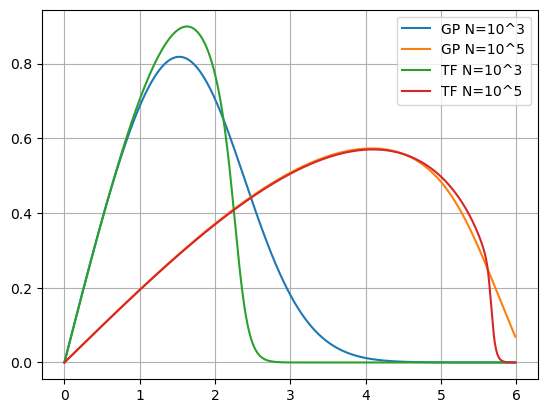

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

scattering_length, width,   step, atom_numbers, time_step, alpha, iterations = \
            0.00433,   400,  0.015,    particles,    0.0001,   0.8,      40000

for exponent in [3, 5]:
    atom_numbers = int(10**exponent)
    alpha2, cvar, interaction, density_param, rs, r2s, psi = \
        initial_values(scattering_length, width, step, atom_numbers, alpha)
    final, local_mu = compute_wavelength(rs, r2s, psi, iterations,step, interaction,time_step, label="N = 10^{0:02d}".format(exponent))
    ax.plot(rs, final, label=f"GP N=10^{exponent}")
    
for exponent in [3, 5]:
    atom_numbers = int(10**exponent)
    alpha2, cvar, interaction, density_param, rs, r2s, psi = \
        initial_values(scattering_length, width, step, atom_numbers, alpha)
    final, local_mu = compute_wavelength_TF(rs, r2s, psi, iterations,step, interaction,time_step, label="N = 10^{0:02d}".format(exponent))
    ax.plot(rs, final, label=f"TF N=10^{exponent}")

ax.grid()
ax.legend()
fig.show()


### d) Teorema del Virial per diferents valors de $N$

Comprovarem que les solucions obtingudes de l'equació GP compleix el Teorema del Virial. 

El teorema del Virial en el marc de l'equació GP és de la forma: 
$$
2\varepsilon_{kin} - 2\varepsilon_{o.h} + 3\varepsilon_{int} = 0
$$

| $N$   | $2\varepsilon_{kin} - 2\varepsilon_{o.h} + 3\varepsilon_{int}$ | $- 2\varepsilon_{o.h}^{TF} + 3\varepsilon_{int}^{TF}$ | 
|:-----:|:-----------:|:-------------:|
|100    |             |     |
|1000   |
|10000  |
|100000 |
|1000000|

comment behaviour...